### TRANING BASE MODELS

## Training DenseNet without weighted losses

In [1]:
# Install necessary libraries (if not already installed)
!pip install torch torchvision
!pip install plotly

# Import necessary libraries
import pandas as pd
import cv2
from tqdm.auto import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
img_path = "Data/images/"
TRAIN_PATH = "Data/train.csv"
TEST_PATH = "Data/test.csv"

train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

### Model traning Standard Loss

In [3]:
train_data

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [4]:
# Constructing the img_path using the base path, image_id, and .jpg extension
train_data['img_path'] = train_data['image_id'].apply(lambda x: f"data/images/{x}.jpg")
# Check if the first image path in the DataFrame exists
print(os.path.exists(train_data['img_path'][0]))  

True


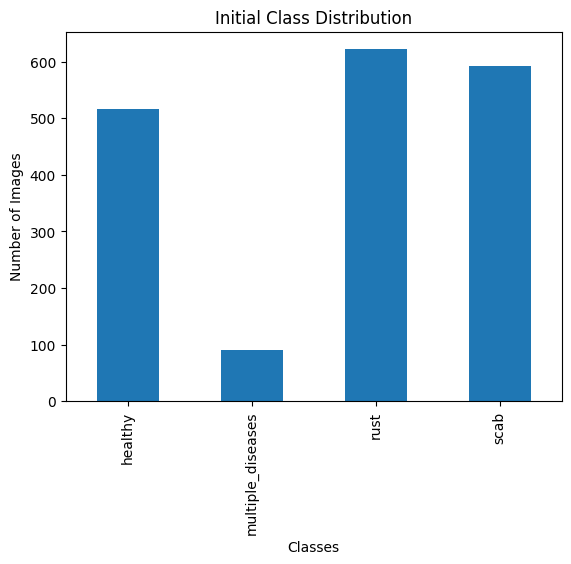

In [5]:
initial_distribution = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
initial_distribution.plot(kind='bar')
plt.title('Initial Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [6]:
labels = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

X_train, X_Val, y_train, y_val = train_test_split(
    train_data['image_id'],  # or df.drop(['label'], axis=1) for features only
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


X_Val, X_test, y_val, y_test = train_test_split(
    X_Val,
    y_val,
    test_size=0.27,  # Split the validation set in half
    random_state=42,
    stratify=y_val
)



In [7]:
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_Val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 1456
Validation set size: 266
Test set size: 99


Training Set Distribution:
 rust                 0.341346
scab                 0.324863
healthy              0.283654
multiple_diseases    0.050137
Name: proportion, dtype: float64
Test Set Distribution:
 rust                 0.342105
scab                 0.327068
healthy              0.281955
multiple_diseases    0.048872
Name: proportion, dtype: float64
Test Set Distribution:
 rust                 0.343434
scab                 0.323232
healthy              0.282828
multiple_diseases    0.050505
Name: proportion, dtype: float64


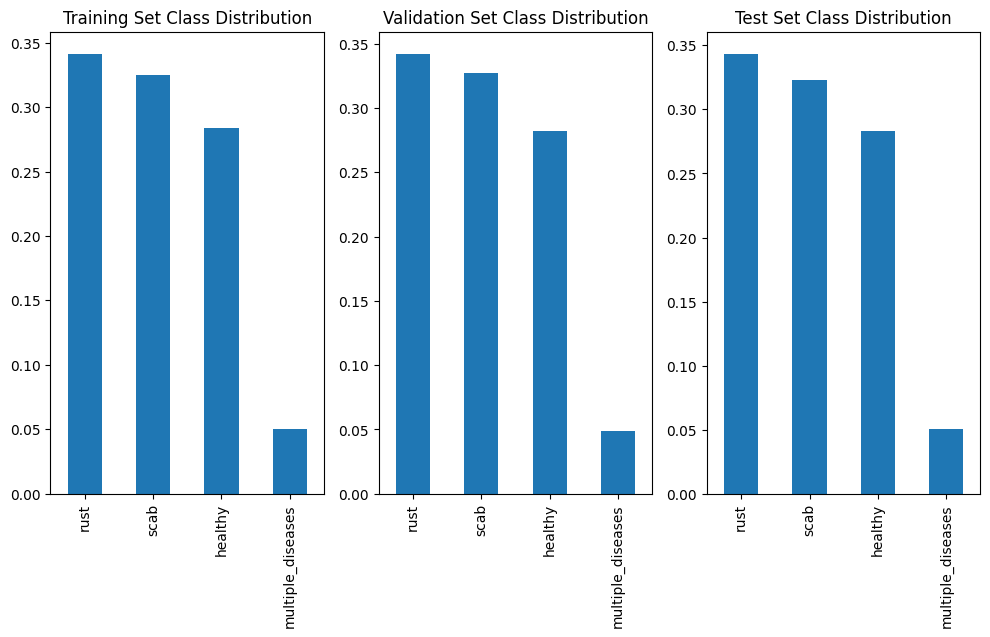

In [8]:
train_distribution = y_train.value_counts(normalize=True)
print("Training Set Distribution:\n", train_distribution)

# Check the distribution in the test set
validation_distribution = y_val.value_counts(normalize=True)
print("Test Set Distribution:\n", validation_distribution)

test_distribution = y_test.value_counts(normalize=True)
print("Test Set Distribution:\n", test_distribution)

# Plot the distributions
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

train_distribution.plot(kind='bar', ax=ax[0], title='Training Set Class Distribution')
validation_distribution.plot(kind='bar', ax=ax[1], title='Validation Set Class Distribution')
test_distribution.plot(kind='bar', ax=ax[2], title='Test Set Class Distribution')



plt.show()

In [9]:

# Define the custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, df, image_ids, labels, transform=None):
        self.df = df
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids.iloc[idx]
        img_path = self.df.loc[self.df['image_id'] == img_id, 'img_path'].values[0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels.iloc[idx]
        return image, torch.tensor(label, dtype=torch.long)

train_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(15),  # Randomly rotate images within a specified degree range
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly jitter brightness, contrast, and saturation
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Randomly apply Gaussian blur
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

valid_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224 for validation
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

test_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the images to match the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader setup
# Mapping string labels to integers
label_mapping = {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}
numerical_y_train = y_train.map(label_mapping)
numerical_y_val = y_val.map(label_mapping)
numerical_y_test = y_test.map(label_mapping)

batch_size = 8

# Creating dataset instances
train_dataset = CustomImageDataset(train_data, X_train, numerical_y_train, transform=train_transformations)
valid_dataset = CustomImageDataset(train_data, X_Val, numerical_y_val, transform=valid_transformations)
test_dataset = CustomImageDataset(train_data, X_test, numerical_y_test, transform=test_transformations)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0)






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


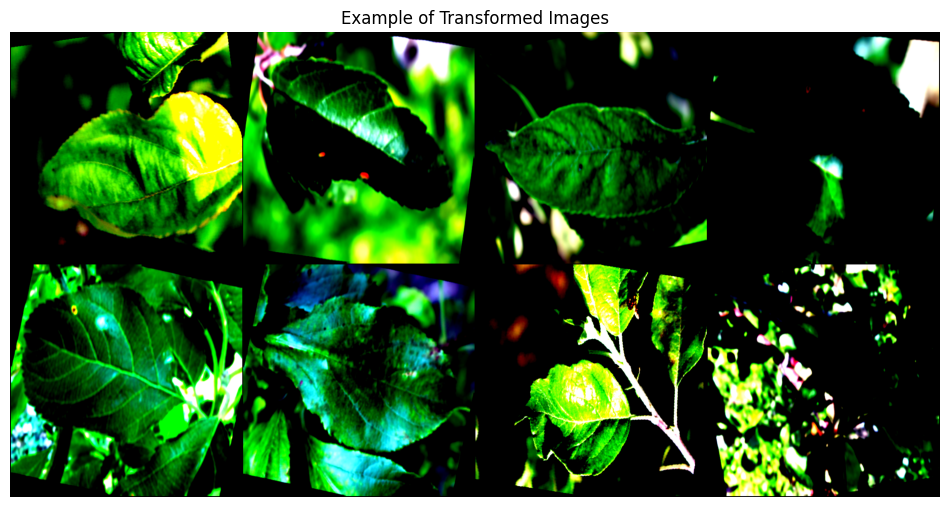

Corresponding labels: tensor([0, 2, 3, 2, 2, 3, 3, 0])


In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_transformed_images(dataloader, num_images=8):
    images, labels = next(iter(dataloader))
    # Create a grid of images
    grid = make_grid(images[:num_images], nrow=4)  # Adjust nrow according to your preference
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # because images are [C, H, W]
    plt.title('Example of Transformed Images')
    plt.axis('off')
    plt.show()
    print("Corresponding labels:", labels[:num_images])

show_transformed_images(train_loader)

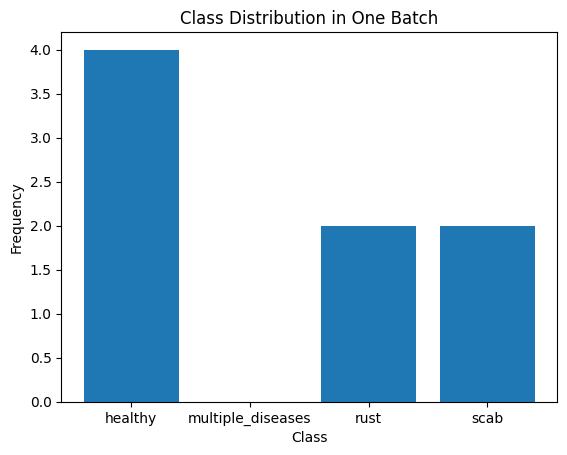

In [11]:
def analyze_class_distribution(dataloader):
    label_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for images, labels in dataloader:
        for label in labels:
            label_counts[label.item()] += 1
        break  # Only process the first batch for demonstration

    # Visualizing the distribution
    labels, counts = zip(*label_counts.items())
    plt.bar(labels, counts, tick_label=[k for k in label_mapping.keys()])
    plt.title('Class Distribution in One Batch')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

analyze_class_distribution(train_loader)

In [12]:
print("lenght of the train_loader",len(train_loader))
print("lenght of the valid_loader",len(valid_loader))
print("lenght of the test_loader",len(test_loader))

lenght of the train_loader 182
lenght of the valid_loader 34
lenght of the test_loader 13


In [13]:
# Set device
if torch.backends.mps.is_available():
    device = "mps"  
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [ ]:
# Install necessary libraries (if not already installed)
!pip install torch torchvision
!pip install plotly

# Import necessary libraries
import pandas as pd
import cv2
from tqdm.auto import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim


# Define the model
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomDenseNet(num_classes=4).to(device)


# Define the validation function
def validate_model(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() 
            _, predicted = torch.max(outputs.data, -1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(valid_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# Define the training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    model.to(device)
    # history = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)


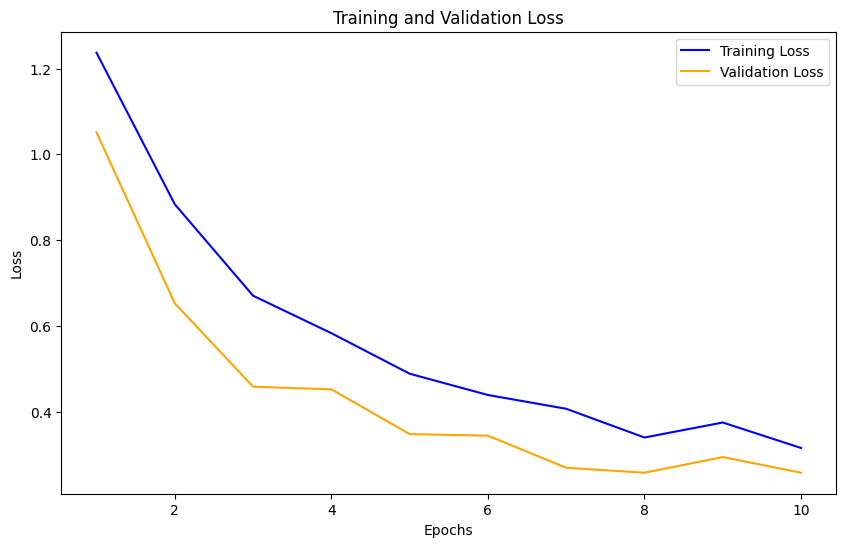

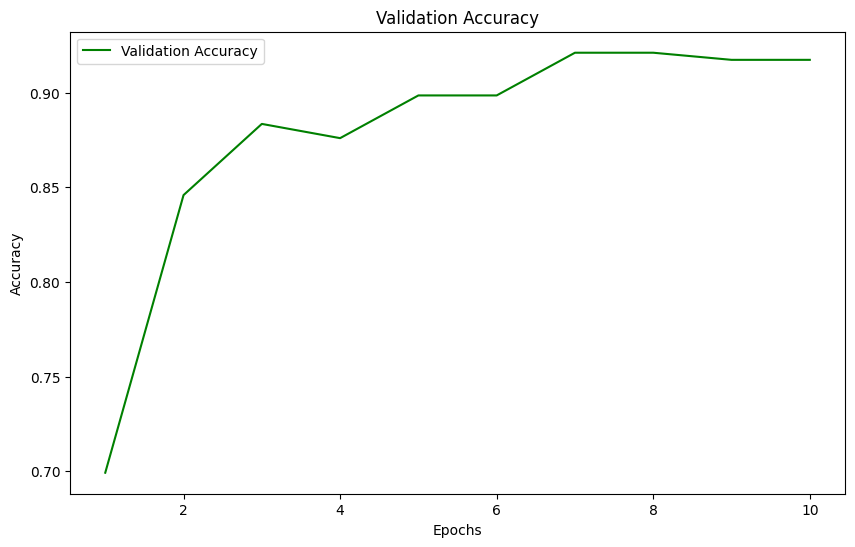

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot both training and validation loss on the same plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['valid_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plot validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['valid_accuracy'], label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

# Call the plotting function with the history
plot_training_history(history)

In [87]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_predictions))

    return all_predictions, all_labels

# Assuming model, valid_loader and device are already defined
# all_prediction, all_lable = evaluate_model(model, test_loader, device)

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(actuals, predictions, classes):
    cm = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

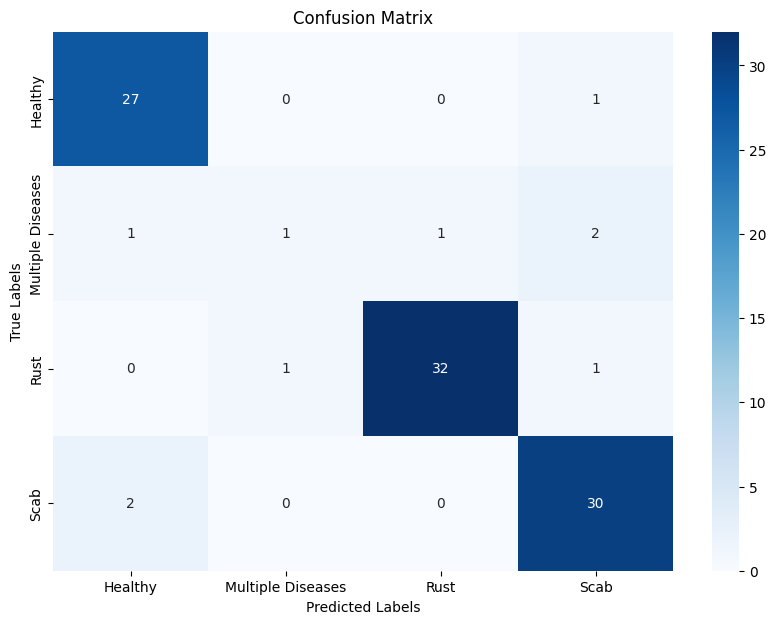

In [ ]:


# Assuming you have actuals and predictions arrays available from the evaluation
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

### 

### Saving the model

In [149]:
torch.save(model.state_dict(), 'model_state_dict_v2.pth')

### Loading the model and Predicitng on the Actually test set

In [78]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm  # Import tqdm for progress bar

class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomDenseNet(num_classes=4).to(device)

# Load the model checkpoint
# if torch.backends.mps.is_available() == "True":
#     device = "mps"
# elif torch.cuda.is_available():
#     device = "cuda"
# else:
#     device = "cpu"

device = "mps"

print(f"Using device: {device}")    

model = CustomDenseNet(num_classes=4).to(device)
print(model)
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: mps
CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_84265/264784464.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Evaluating the Test Data

In [80]:
# Assuming `test_data` from a DataFrame that includes paths and potential 'image_id'
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define test transformations with the correct resizing if it's 448x448
test_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224 for validation
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load test images with corrected paths
test_dataset = TestDataset(test_data['img_path'].values, transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Rest of the code remains largely unchanged

# Prediction function
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting", unit="batch"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            predictions.extend(probs.cpu().numpy())  # Move to CPU and convert to NumPy for easier handling
    return predictions

# Run predictions with progress tracking
predictions = predict(model, test_loader, device)

# Create a DataFrame for submission
sub = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
sub['image_id'] = test_data['image_id']  # Assuming 'image_id' column exists in test_data
sub = sub[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]  # Arrange columns as required
print(sub.head())

Predicting:   0%|          | 0/228 [00:00<?, ?batch/s]

  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000244           0.001591  0.998146  0.000018
1   Test_1  0.009420           0.062232  0.925367  0.002981
2   Test_2  0.011725           0.002070  0.000265  0.985940
3   Test_3  0.999289           0.000098  0.000492  0.000121
4   Test_4  0.000352           0.001514  0.998045  0.000089


## Traning DenseNet with weighted Loss

In [14]:
from sklearn.utils.class_weight import compute_class_weight

# labels should be a 1D array of all label indices for the dataset
labels = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(class_weights_tensor)

tensor([0.8823, 5.0027, 0.7319, 0.7690], device='mps:0')


In [ ]:
# Define the training function
def train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    model = CustomDenseNet(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    model.to(device)
    history = train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for 10 epochs.


Epoch 1:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1 completed. Average Loss: 1.230256831580466
Validation Loss: 1.0002, Validation Accuracy: 0.7068


Epoch 2:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2 completed. Average Loss: 0.8510106476126137
Validation Loss: 0.6470, Validation Accuracy: 0.8045


Epoch 3:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3 completed. Average Loss: 0.6624432673657333
Validation Loss: 0.4844, Validation Accuracy: 0.8647


Epoch 4:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 4 completed. Average Loss: 0.528110642354567
Validation Loss: 0.3586, Validation Accuracy: 0.8872


Epoch 5:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 5 completed. Average Loss: 0.46408326850160136
Validation Loss: 0.3279, Validation Accuracy: 0.8835


Epoch 6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 6 completed. Average Loss: 0.41461921315435524
Validation Loss: 0.2621, Validation Accuracy: 0.9173


Epoch 7:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 7 completed. Average Loss: 0.3921354395838884
Validation Loss: 0.2471, Validation Accuracy: 0.9398


Epoch 8:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 8 completed. Average Loss: 0.3364153697186119
Validation Loss: 0.2451, Validation Accuracy: 0.9248


Epoch 9:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 9 completed. Average Loss: 0.35911625531594177
Validation Loss: 0.2142, Validation Accuracy: 0.9398


Epoch 10:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 10 completed. Average Loss: 0.2992438376973291
Validation Loss: 0.2143, Validation Accuracy: 0.9436
Training completed.


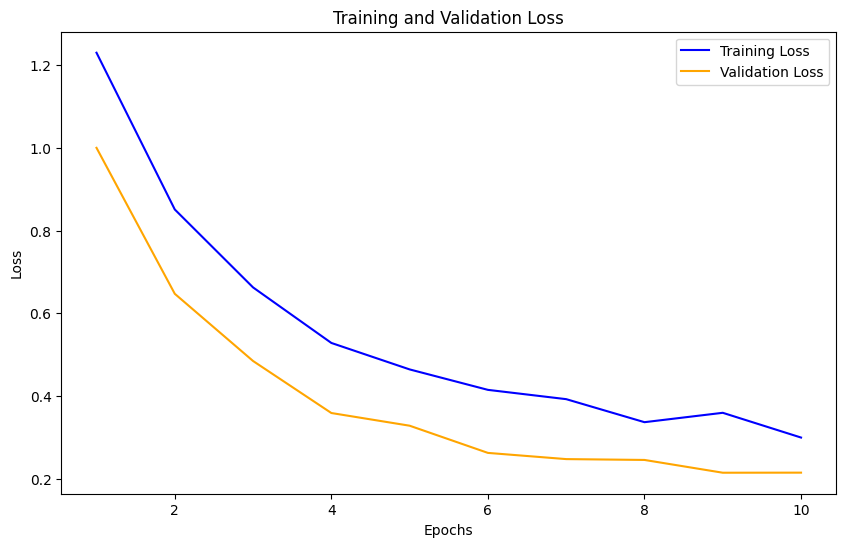

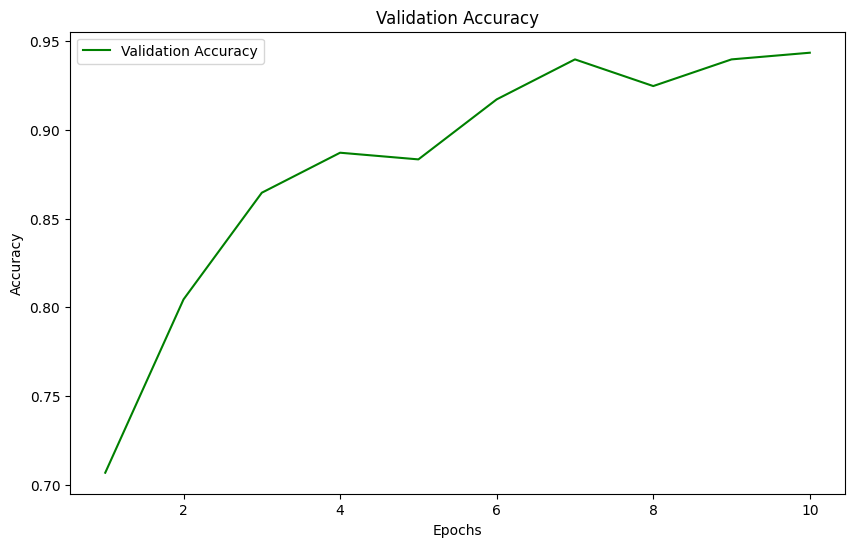

In [157]:
plot_training_history(history)

In [158]:
all_prediction, all_lable = evaluate_model(model, test_loader, device)

Precision: 0.8602
Recall: 0.8623
F1 Score: 0.8601

Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       0.60      0.60      0.60         5
           2       1.00      0.91      0.95        34
           3       0.94      0.94      0.94        32

    accuracy                           0.93        99
   macro avg       0.86      0.86      0.86        99
weighted avg       0.93      0.93      0.93        99



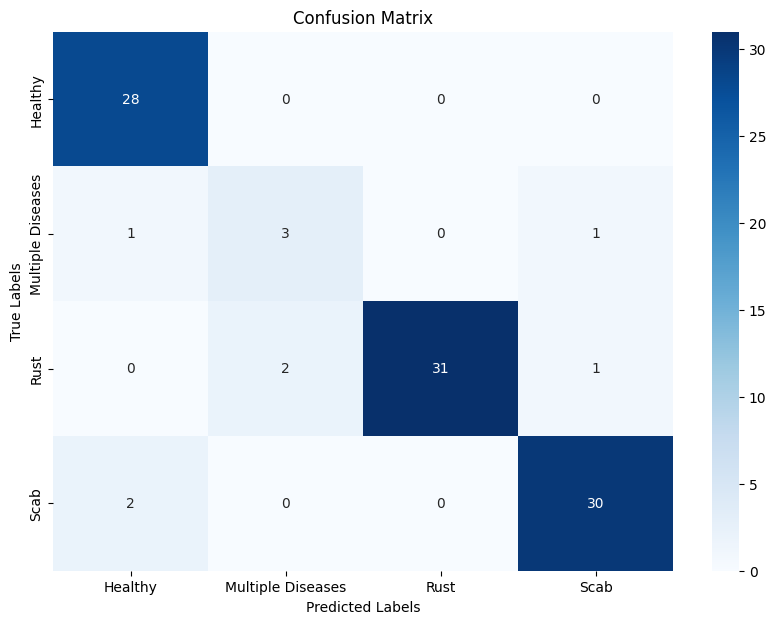

In [159]:
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

### Model Performance Comparison: Before and After Weighted Loss Implementation

#### Metrics After Implementing Weighted Loss:
- **Precision**: 0.8602
- **Recall**: 0.8623
- **F1 Score**: 0.8601

**Classification Report (After Weighted Loss):**
| Class              | Precision | Recall | F1 Score | Support |
|--------------------|-----------|--------|----------|---------|
| Healthy            | 0.90      | 1.00   | 0.95     | 28      |
| Multiple Diseases  | 0.60      | 0.60   | 0.60     | 5       |
| Rust               | 1.00      | 0.91   | 0.95     | 34      |
| Scab               | 0.94      | 0.94   | 0.94     | 32      |
| **Accuracy**       |           |        | 0.93     | 99      |
| **Macro Avg**      | 0.86      | 0.86   | 0.86     | 99      |
| **Weighted Avg**   | 0.93      | 0.93   | 0.93     | 99      |

#### Metrics Before Implementing Weighted Loss:
- **Precision**: 0.8130
- **Recall**: 0.7607
- **F1 Score**: 0.7703

**Classification Report (Before Weighted Loss):**
| Class              | Precision | Recall | F1 Score | Support |
|--------------------|-----------|--------|----------|---------|
| Healthy            | 0.90      | 0.96   | 0.93     | 28      |
| Multiple Diseases  | 0.50      | 0.20   | 0.29     | 5       |
| Rust               | 0.97      | 0.94   | 0.96     | 34      |
| Scab               | 0.88      | 0.94   | 0.91     | 32      |
| **Accuracy**       |           |        | 0.91     | 99      |
| **Macro Avg**      | 0.81      | 0.76   | 0.77     | 99      |
| **Weighted Avg**   | 0.90      | 0.91   | 0.90     | 99      |

### Analysis
Implementing weighted loss significantly improved the precision, recall, and F1 score for the 'Multiple Diseases' class, elevating overall model accuracy and balancing performance across classes. The macro and weighted averages show a clear uplift, highlighting the effectiveness of addressing class imbalance in training.

In [160]:
torch.save(model.state_dict(), 'model_state_dict_v3.pth')

In [91]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm  # Import tqdm for progress bar

class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomDenseNet(num_classes=4).to(device)

# Load the model checkpoint
# if torch.backends.mps.is_available() == "True":
#     device = "mps"
# elif torch.cuda.is_available():
#     device = "cuda"
# else:
#     device = "cpu"

device = "mps"

print(f"Using device: {device}")    

model = CustomDenseNet(num_classes=4).to(device)
print(model)
model.load_state_dict(torch.load('model_state_dict_v3.pth'))
model.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: mps
CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_5183/3121815602.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [161]:
# Assuming `test_data` from a DataFrame that includes paths and potential 'image_id'
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define test transformations with the correct resizing if it's 448x448
test_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224 for validation
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load test images with corrected paths
test_dataset = TestDataset(test_data['img_path'].values, transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Rest of the code remains largely unchanged

# Prediction function
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting", unit="batch"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            predictions.extend(probs.cpu().numpy())  # Move to CPU and convert to NumPy for easier handling
    return predictions

# Run predictions with progress tracking
predictions = predict(model, test_loader, device)

# Create a DataFrame for submission
sub = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
sub['image_id'] = test_data['image_id']  # Assuming 'image_id' column exists in test_data
sub = sub[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]  # Arrange columns as required
print(sub.head())

Predicting:   0%|          | 0/228 [00:00<?, ?batch/s]

  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.002238           0.025991  0.971648  0.000123
1   Test_1  0.034468           0.201440  0.753512  0.010580
2   Test_2  0.008344           0.004730  0.000323  0.986604
3   Test_3  0.997062           0.000231  0.002291  0.000417
4   Test_4  0.001212           0.012212  0.985433  0.001143


## Train EfficientNetB1 with Weighted Loss:

In [ ]:
def custom_efficientnetB1(num_classes, pretrained=True):
    model = models.efficientnet_b1(pretrained=pretrained)
    num_features = model.classifier[1].in_features  # Get the input feature count of the classifier
    model.classifier[1] = nn.Linear(num_features, num_classes)  # Replace the classifier with a new one
    return model

In [20]:
def validate_model(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() 
            _, predicted = torch.max(outputs.data, -1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(valid_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define the training function
def train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")



        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        scheduler.step(valid_loss)  # This ensures the scheduler sees the validation loss
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    EfficientNetmodelB1 = custom_efficientnetB1(num_classes=4,pretrained = True).to(device)
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(EfficientNetmodelB1.parameters(), lr=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    EfficientNetmodelB1.to(device)
    print("device",device)
    history = train_model_weighted_loss(EfficientNetmodelB1, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)
    torch.save(EfficientNetmodelB1.state_dict(), 'model_state_dict_WEIGHTED_EFFICENTNET.pth')  

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /Users/pratheeshjp/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:01<00:00, 23.6MB/s]


device mps
Starting training for 10 epochs.


/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1 completed. Average Loss: 0.6725715332879469
Validation Loss: 0.4020, Validation Accuracy: 0.8722


Epoch 2:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2 completed. Average Loss: 0.3083444756179393
Validation Loss: 0.3426, Validation Accuracy: 0.8872


Epoch 3:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3 completed. Average Loss: 0.25783690725258746
Validation Loss: 0.3507, Validation Accuracy: 0.8910


Epoch 4:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 4 completed. Average Loss: 0.1969819476336732
Validation Loss: 0.2867, Validation Accuracy: 0.9286


Epoch 5:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 5 completed. Average Loss: 0.17532801306755333
Validation Loss: 0.2330, Validation Accuracy: 0.9398


Epoch 6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 6 completed. Average Loss: 0.14576787239063407
Validation Loss: 0.2062, Validation Accuracy: 0.9323


Epoch 7:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 7 completed. Average Loss: 0.1132003187360549
Validation Loss: 0.1854, Validation Accuracy: 0.9549


Epoch 8:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 8 completed. Average Loss: 0.10715542814712255
Validation Loss: 0.1315, Validation Accuracy: 0.9699


Epoch 9:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 9 completed. Average Loss: 0.09180396742949896
Validation Loss: 0.1436, Validation Accuracy: 0.9699


Epoch 10:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 10 completed. Average Loss: 0.08061898463523363
Validation Loss: 0.1662, Validation Accuracy: 0.9586
Training completed.


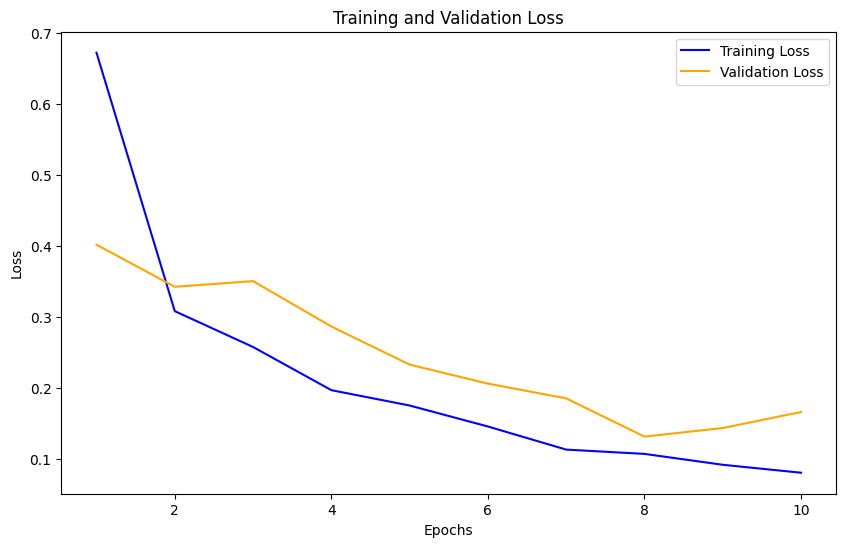

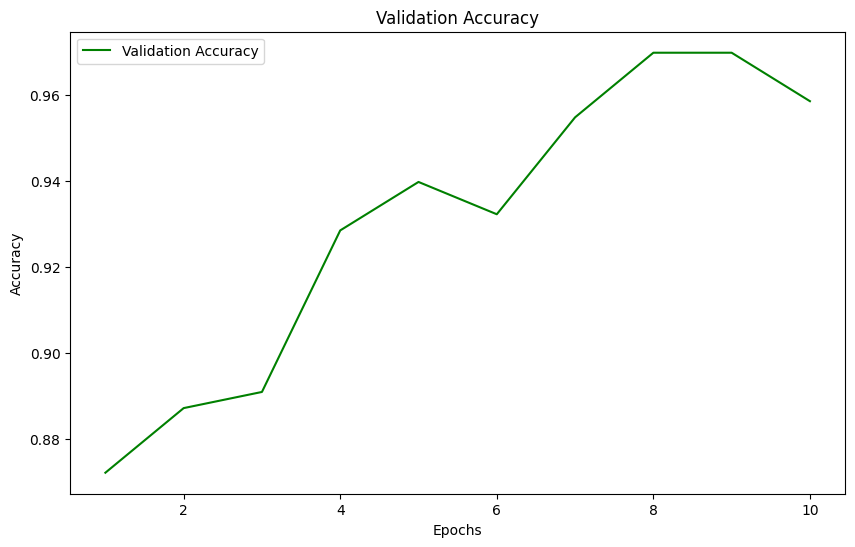

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot both training and validation loss on the same plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['valid_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plot validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['valid_accuracy'], label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

# Call the plotting function with the history
plot_training_history(history)

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_predictions))

    return all_predictions, all_labels

# Assuming model, valid_loader and device are already defined
# all_prediction, all_lable = evaluate_model(model, test_loader, device)
all_prediction, all_lable = evaluate_model(EfficientNetmodel, test_loader, device)

Precision: 0.8759
Recall: 0.8759
F1 Score: 0.8759

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.60      0.60      0.60         5
           2       0.97      0.97      0.97        34
           3       0.97      0.97      0.97        32

    accuracy                           0.95        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.95      0.95      0.95        99



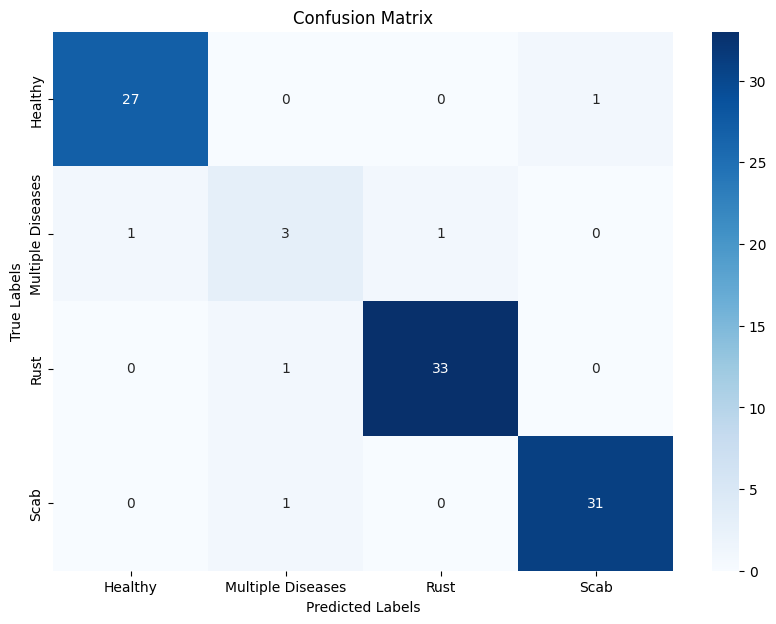

In [30]:
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

## DenseNet121 vs EfficientNetB1 Performance Comparison

### **DenseNet121 Performance Summary**
- **Overall Metrics:**
  - **Precision**: 0.8602
  - **Recall**: 0.8623
  - **F1 Score**: 0.8601
  - **Accuracy**: 93%

- **Class-wise Metrics:**
  - **Class 0**: Precision = 0.90, Recall = 1.00, F1 = 0.95 (High performance)
  - **Class 1**: Precision = 0.60, Recall = 0.60, F1 = 0.60 (Lowest performance)
  - **Class 2**: Precision = 1.00, Recall = 0.91, F1 = 0.95 (High performance)
  - **Class 3**: Precision = 0.94, Recall = 0.94, F1 = 0.94 (High performance)

### **EfficientNetB1 Performance Summary**
- **Overall Metrics:**
  - **Precision**: 0.8759
  - **Recall**: 0.8759
  - **F1 Score**: 0.8759
  - **Accuracy**: 95%

- **Class-wise Metrics:**
  - **Class 0**: Precision = 0.96, Recall = 0.96, F1 = 0.96 (High performance)
  - **Class 1**: Precision = 0.60, Recall = 0.60, F1 = 0.60 (Consistent with DenseNet, still the lowest)
  - **Class 2**: Precision = 0.97, Recall = 0.97, F1 = 0.97 (Slightly better than DenseNet)
  - **Class 3**: Precision = 0.97, Recall = 0.97, F1 = 0.97 (Slightly better than DenseNet)

### Analysis
- **Accuracy**: EfficientNetB1 outperforms DenseNet121 by 2% in accuracy, suggesting slightly better overall classification ability.
- **Macro Averages**: EfficientNetB1 shows slightly higher macro averages across precision, recall, and F1 score, indicating more balanced performance across classes.
- **Class 1 Performance**: Both models struggle with Class 1, achieving only 60% across precision, recall, and F1. This suggests issues with either class representation or distinctiveness from other classes.
- **High Performance Classes**: Both models perform exceptionally well on Classes 2 and 3, with EfficientNetB1 showing a marginal improvement.


## Train EfficientNetB2 with Weighted Loss:

In [46]:
def custom_efficientnetB2(num_classes, pretrained=True):
    # Load a pre-trained EfficientNet
    model = models.efficientnet_b2(pretrained=pretrained)
    
    # Replace the classifier
    num_features = model.classifier[1].in_features  # Get the input feature count of the classifier
    model.classifier[1] = nn.Linear(num_features, num_classes)  # Replace the classifier with a new one
    
    return model

In [47]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define the training function
def train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")



        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        scheduler.step(valid_loss)  # This ensures the scheduler sees the validation loss
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    EfficientNetmodelB2 = custom_efficientnetB2(num_classes=4,pretrained = True).to(device)
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(EfficientNetmodelB2.parameters(), lr=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    EfficientNetmodelB2.to(device)
    print("device",device)
    history = train_model_weighted_loss(EfficientNetmodelB2, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)
    torch.save(EfficientNetmodelB2.state_dict(), 'model_state_dict_WEIGHTED_EFFICENTNETB2.pth')  

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device mps
Starting training for 10 epochs.


/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1 completed. Average Loss: 0.6148132629856303
Validation Loss: 0.6188, Validation Accuracy: 0.7556


Epoch 2:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2 completed. Average Loss: 0.3065102877770806
Validation Loss: 0.3143, Validation Accuracy: 0.8910


Epoch 3:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3 completed. Average Loss: 0.24229720587954745
Validation Loss: 0.2653, Validation Accuracy: 0.9173


Epoch 4:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 4 completed. Average Loss: 0.17965370720088647
Validation Loss: 0.3578, Validation Accuracy: 0.9098


Epoch 5:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 5 completed. Average Loss: 0.1696456053580802
Validation Loss: 0.3080, Validation Accuracy: 0.9211


Epoch 6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 6 completed. Average Loss: 0.10086531454318581
Validation Loss: 0.3868, Validation Accuracy: 0.9060


Epoch 7:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 7 completed. Average Loss: 0.10744045989506029
Validation Loss: 0.3137, Validation Accuracy: 0.9173


Epoch 8:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 8 completed. Average Loss: 0.08839983172116003
Validation Loss: 0.2516, Validation Accuracy: 0.9323


Epoch 9:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 9 completed. Average Loss: 0.0770402137678792
Validation Loss: 0.2101, Validation Accuracy: 0.9511


Epoch 10:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 10 completed. Average Loss: 0.060638212548967986
Validation Loss: 0.2167, Validation Accuracy: 0.9436
Training completed.


In [49]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_predictions))

    return all_predictions, all_labels

evaluate_model(EfficientNetmodelB2, test_loader, device)

Precision: 0.8964
Recall: 0.8665
F1 Score: 0.8792

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.75      0.60      0.67         5
           2       0.97      1.00      0.99        34
           3       0.97      0.94      0.95        32

    accuracy                           0.94        99
   macro avg       0.90      0.87      0.88        99
weighted avg       0.94      0.94      0.94        99



([3,
  0,
  3,
  2,
  2,
  3,
  3,
  2,
  2,
  3,
  2,
  0,
  3,
  3,
  3,
  3,
  2,
  2,
  3,
  2,
  3,
  2,
  3,
  0,
  3,
  3,
  2,
  2,
  1,
  0,
  2,
  0,
  3,
  1,
  0,
  0,
  3,
  0,
  3,
  3,
  2,
  3,
  3,
  3,
  0,
  3,
  3,
  0,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  0,
  3,
  2,
  0,
  0,
  2,
  2,
  0,
  3,
  0,
  3,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  2,
  3,
  0,
  2,
  0,
  0,
  2,
  3,
  3,
  0,
  2,
  2,
  3,
  1,
  2,
  2,
  2,
  0,
  2,
  1,
  2,
  0,
  2,
  2],
 [3,
  0,
  3,
  2,
  2,
  3,
  3,
  2,
  2,
  3,
  2,
  0,
  3,
  3,
  3,
  3,
  2,
  2,
  3,
  2,
  3,
  2,
  3,
  0,
  3,
  3,
  2,
  2,
  0,
  3,
  2,
  0,
  3,
  1,
  0,
  0,
  3,
  0,
  3,
  3,
  2,
  3,
  1,
  3,
  0,
  3,
  3,
  0,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  0,
  3,
  2,
  3,
  0,
  2,
  0,
  0,
  3,
  0,
  3,
  0,
  0,
  2,
  0,
  1,
  0,
  0,
  2,
  3,
  0,
  2,
  0,
  0,
  2,
  3,
  3,
  0,
  2,
  2,
  3,
  1,
  2,
  2,
  2,
  0,
  2,
  1,
  2,
  0,
  2,
  2])

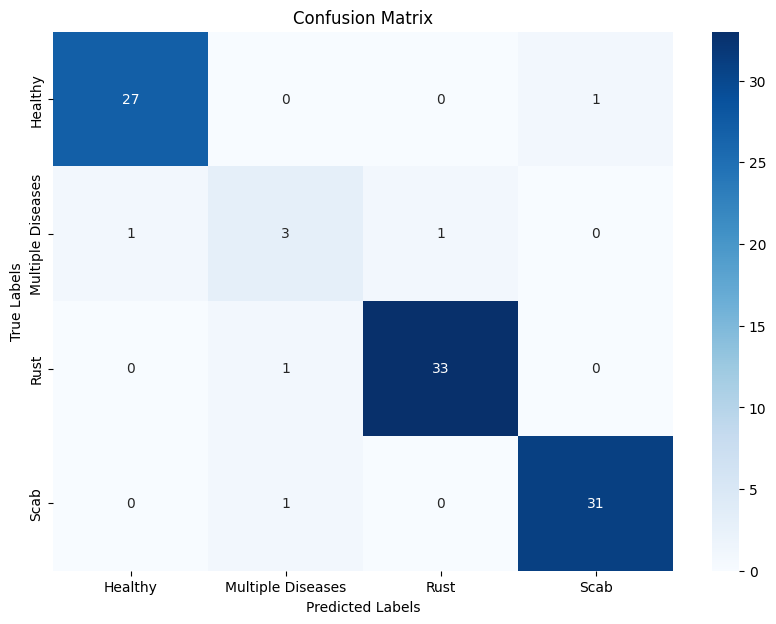

In [50]:
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

### Stacking Ensemble

In [56]:
EfficientNetmodelB1 = custom_efficientnetB1(num_classes=4).to(device)
# print(EfficientNetmodel)
EfficientNetmodelB1.load_state_dict(torch.load('model/model_state_dict_WEIGHTED_EFFICENTNET.pth'))
EfficientNetmodelB1.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_20503/2476112747.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [57]:
# Define the model
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
# Load the model checkpoint
denseNetModel  = CustomDenseNet(num_classes=4).to(device)
denseNetModel.load_state_dict(torch.load('model/model_state_dict_DenseNet_Weighted_loss_V2.pth'))
denseNetModel.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_20503/725858308.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [58]:
EfficientNetmodelB2 = custom_efficientnetB2(num_classes=4).to(device)
EfficientNetmodelB2.load_state_dict(torch.load('model_state_dict_WEIGHTED_EFFICENTNETB2.pth'))
EfficientNetmodelB2.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_20503/639443208.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed durin

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [71]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

def predict_with_ensemble(models, dataloader):
    all_predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            # Collect predictions from all models
            outputs = [model(inputs) for model in models]
            # Majority voting
            outputs = torch.stack(outputs)  # Shape (num_models, batch_size, num_classes)
            outputs = torch.mean(outputs, dim=0)  # Averaging predictions
            _, predicted = torch.max(outputs, 1)  # Convert probabilities to class predictions
            all_predictions.extend(predicted.cpu().numpy())
    return all_predictions




models = [denseNetModel, EfficientNetmodelB1,EfficientNetmodelB2]
ensemble_predictions = predict_with_ensemble(models, test_loader)


In [72]:
true_label = [label for _, label in test_loader]
true_label = [item.item() for tensor in true_label for item in tensor]
# print(true_label)
# print(ensemble_predictions)


In [74]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_score(all_labels, all_predictions):
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_predictions))

    return all_predictions, all_labels

all_predictions,all_labels = evaluate_score(true_label, ensemble_predictions)


Precision: 0.9000
Recall: 0.9275
F1 Score: 0.9117

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       0.67      0.80      0.73         5
           2       1.00      0.94      0.97        34
           3       1.00      0.97      0.98        32

    accuracy                           0.96        99
   macro avg       0.90      0.93      0.91        99
weighted avg       0.96      0.96      0.96        99



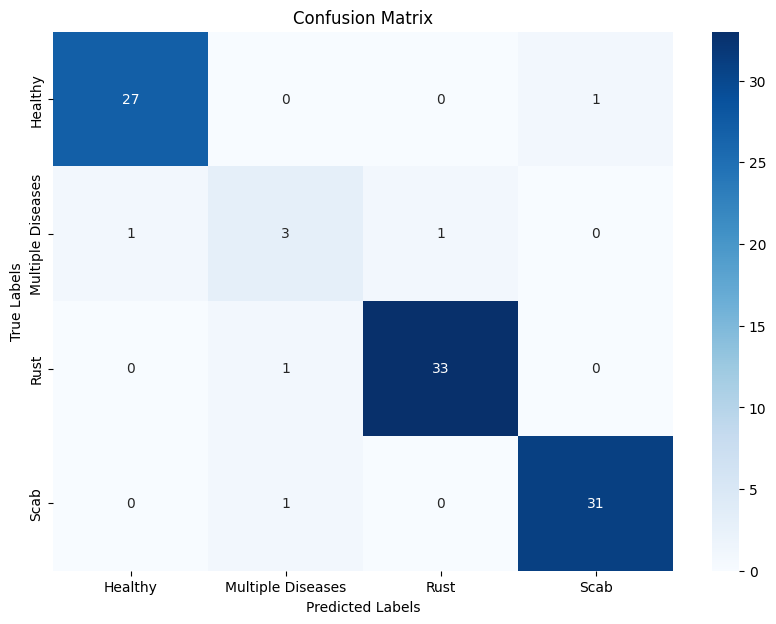

In [75]:
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

## Model Performance Comparison and Analysis

### DenseNet121 (After Implementing Weighted Loss):
- **Precision:** 0.8602
- **Recall:** 0.8623
- **F1 Score:** 0.8601
- **Accuracy:** 93%
- **Detailed Performance:**
  - Shows significant improvement in handling the 'Multiple Diseases' category compared to before implementing weighted loss.

### EfficientNetB1 (Weighted Loss):
- **Precision:** 0.8759
- **Recall:** 0.8759
- **F1 Score:** 0.8759
- **Accuracy:** 95%
- **Detailed Performance:**
  - Consistently high performance across all categories, with particular strength in handling 'Rust' and 'Scab'.

### Ensemble Method (Voting Ensemble of DenseNet121 and EfficientNet variants):
- **Precision:** 0.9000
- **Recall:** 0.9275
- **F1 Score:** 0.9117
- **Accuracy:** 96%
- **Detailed Performance:**
  - The ensemble method enhances the overall accuracy and class-specific metrics, especially improving the precision and recall for 'Multiple Diseases'.

## Analysis
- The use of weighted loss in both DenseNet121 and EfficientNetB1 has shown a noticeable improvement in metrics, particularly in balancing class performance, which is evident in the increased scores for the 'Multiple Diseases' class.
- EfficientNetB1 slightly outperforms DenseNet121 in almost all metrics, making it a better individual model choice for this specific dataset.
- The ensemble method, combining predictions from both DenseNet121 and EfficientNet models, achieves the best overall performance. This approach effectively leverages the strengths of both models, resulting in higher accuracy and more robust predictions across all classes.

## Recommendations
- **Explore Further Ensemble Techniques:** Beyond simple averaging, more sophisticated ensemble methods like stacking or boosting could potentially yield even better results.
- **Focus on Underperforming Classes:** While improvements have been seen with weighted loss, there's still room for targeted data augmentation or advanced techniques like SMOTE to address class imbalance, particularly for 'Multiple Diseases'.
- **Optimization and Experimentation:** Continue to experiment with learning rate adjustments, augmentation strategies, and potentially integrating additional model architectures into the ensemble to enhance performance.